In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import pickle

In [12]:
DATA_DIR = '/home/shuangni/scratch/Alzheimer_data/data/'
data = sc.read(DATA_DIR + 'msPHATE_data_raw.h5ad')
print(data.shape)

(82159, 32738)


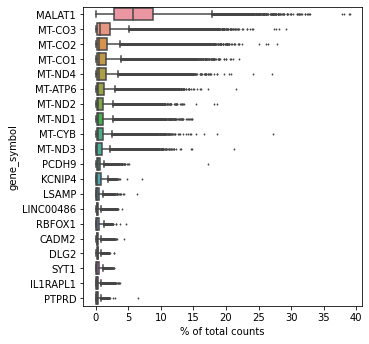

In [5]:
# plot highly expressed genes
sc.pl.highest_expr_genes(data, n_top=20, )

In [14]:
data.var['mt'] = data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

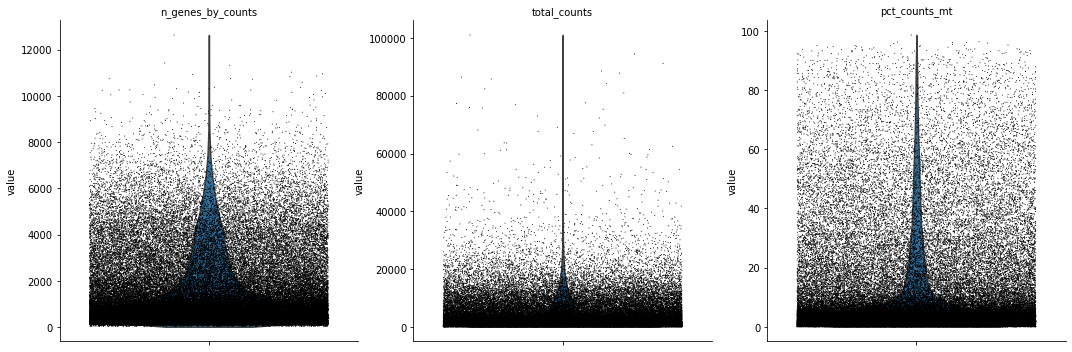

In [7]:
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [15]:
# remove mitochondrial gene counts
data = data[:,~data.var['mt']]
print(data.shape)

(82159, 32725)


In [16]:
# filter out cells with too high mitochondrial gene count
data = data[data.obs.pct_counts_mt < 5, :]
print(data.shape)

(47031, 32725)


In [17]:
# filter out cells with too few/many counts and genes
data = data[data.obs.n_genes_by_counts < 8000, :]
print(data.shape)
data = data[data.obs.total_counts < 25000, :]
print(data.shape)

(46925, 32725)
(46584, 32725)


In [18]:
sc.pp.filter_cells(data, min_genes=200)
print(data.shape)
sc.pp.filter_genes(data, min_cells=2)
print(data.shape)

/home/shuangni/AlzheimerProject/alz_env3.8/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


(46012, 32725)
(46012, 27820)


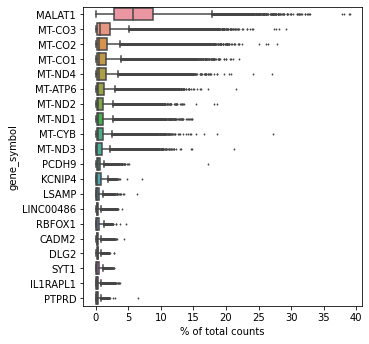

In [13]:
# plot highly expressed genes
sc.pl.highest_expr_genes(data, n_top=20)

In [19]:
sc.pp.normalize_total(data, target_sum=1e4)
print(data.shape)
sc.pp.log1p(data)
print(data.shape)

(46012, 27820)
(46012, 27820)


# Celltype identification

In [ ]:
sc.pp.pca(data)

sc.pp.neighbors(data, n_pcs=15, n_neighbors=30)

sc.tl.umap(data, min_dist=0.5, spread=1)

In [ ]:
# cluster data (lower resolution = fewer clusters)
sc.tl.leiden(data, resolution=0.1)

In [ ]:
# identify neurons
s = 8
with plt.rc_context({'figure.figsize':[s,s]}):
    # Ex
    sc.pl.umap(data, color=['leiden', 'CAMK2A', 'SLC17A7'], size=15, legend_loc='on data')

    # In
    sc.pl.umap(data, color=['leiden', 'GAD1'], size=15, legend_loc='on data')

    # Oli
    sc.pl.umap(data, color=['leiden', 'MOG', 'MOBP'], size=15, legend_loc='on data')

In [ ]:
s = 8
size = 60
with plt.rc_context({'figure.figsize':[s,s]}):
    # Mic
    sc.pl.umap(data, color=['leiden', 'CD74', 'C3'], size=size, legend_loc='on data', title='Mic');

    # End
    sc.pl.umap(data, color=['leiden', 'CLDN5'], size=size, legend_loc='on data', title='End') # PECAM1, CDH5, TIE1

    # lymphocytes
    sc.pl.umap(data, color=['leiden', 'IL7R', 'MS4A1'], size=size, legend_loc='on data', title='lymphocyte')

    # perivascular macrophages (non-microglia macrophages)
    sc.pl.umap(data, color=['leiden', 'CD163', 'SIGLEC1'], size=size, legend_loc='on data', title='macrophage') # MRC1, LYVE1

    # Ast
    sc.pl.umap(data, color=['leiden', 'GFAP', 'AQP4'], size=size, legend_loc='on data', title='Ast')

    # Opc
    sc.pl.umap(data, color=['leiden', 'PDGFRA', 'VCAN'], size=size, legend_loc='on data', title='Opc')

In [ ]:
# assign clusters to celltypes
celltype_leiden = {'Ast':[], 'Opc':[], 'Mic':[0], 'End':[], 'Mac':[], 'Lymph':[]}
def assign_celltype(row):
    for cell in celltype_leiden.keys():
        if(int(row['leiden']) in celltype_leiden[cell]):
            return cell
    
    return 'Other'

data.obs['celltype'] = data.obs.apply(lambda row: assign_celltype(row), axis=1)